In [127]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [128]:
df = pd.read_csv('./MSFT.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-21,217.550003,224.000000,217.279999,222.589996,220.739685,37181900
1,2020-12-22,222.690002,225.630005,221.850006,223.940002,222.078476,22612200
2,2020-12-23,223.110001,223.559998,220.800003,221.020004,219.182739,18699600
3,2020-12-24,221.419998,223.610001,221.199997,222.750000,220.898361,10550600
4,2020-12-28,224.449997,226.029999,223.020004,224.960007,223.089996,17933500


In [129]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [130]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 1000, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/pyt

epoch: 10, total rewards: 722.100023.3, cost: -17838.474609, total money: 8018.720049
epoch: 20, total rewards: 577.110079.3, cost: -19130.832031, total money: 6949.390078
epoch: 30, total rewards: 831.230105.3, cost: -18849.113281, total money: 6670.070102
epoch: 40, total rewards: 780.400041.3, cost: -17786.449219, total money: 3873.270067
epoch: 50, total rewards: 648.600018.3, cost: -20582.927734, total money: 5268.340038
epoch: 60, total rewards: 993.909957.3, cost: -16553.736328, total money: 1563.489944
epoch: 70, total rewards: 901.579975.3, cost: -16998.412109, total money: 1558.469959
epoch: 80, total rewards: 788.689941.3, cost: -18075.164062, total money: 1372.909911
epoch: 90, total rewards: 671.359907.3, cost: -21399.068359, total money: 3556.019911
epoch: 100, total rewards: 1028.750000.3, cost: -17678.783203, total money: 1935.140015
epoch: 110, total rewards: 1508.320006.3, cost: -13411.791016, total money: 1758.809934
epoch: 120, total rewards: 729.630051.3, cost: -21

In [133]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 223.940002, total balance 9776.059998
day 2, sell 1 unit at price 221.020004, investment -1.303920 %, total balance 9997.080002,
day 3: buy 1 unit at price 222.750000, total balance 9774.330002
day 4: buy 1 unit at price 224.960007, total balance 9549.369995
day 5, sell 1 unit at price 224.149994, investment 0.628505 %, total balance 9773.519989,
day 7, sell 1 unit at price 222.419998, investment -1.129094 %, total balance 9995.939987,
day 11: buy 1 unit at price 218.289993, total balance 9777.649994
day 13, sell 1 unit at price 217.490005, investment -0.366479 %, total balance 9995.139999,
day 23: buy 1 unit at price 232.330002, total balance 9762.809997
day 24, sell 1 unit at price 232.899994, investment 0.245337 %, total balance 9995.709991,
day 25: buy 1 unit at price 238.929993, total balance 9756.779998
day 29: buy 1 unit at price 243.000000, total balance 9513.779998
day 31, sell 1 unit at price 242.199997, investment 1.368603 %, total balance 9755.979

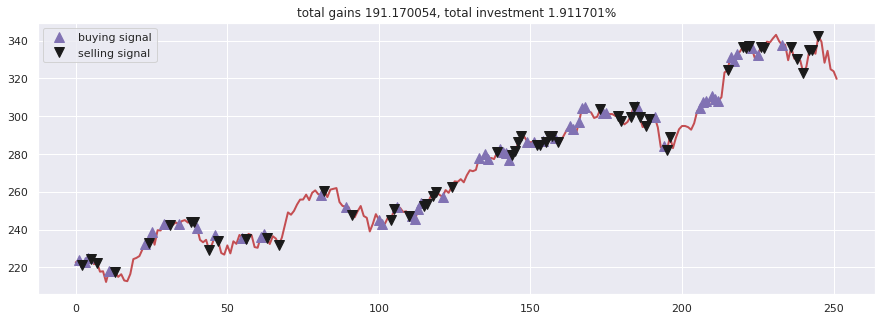

In [132]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()